<a href="https://colab.research.google.com/github/IFuentesSR/AET_moderate_eval/blob/main/AET_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='upbeat-imprint-269809')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
TC = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").select('aet')
PML = ee.ImageCollection("CAS/IGSNRR/PML/V2_v017")
MOD = ee.ImageCollection("MODIS/006/MOD16A2")

In [6]:
geometry = ee.Geometry.MultiPoint(
        [[-69.06506372005273, -21.758295486762478],
         [-70.61251304538965, -30.616437051853968],
         [-70.54659507663965, -29.7236312070661],
         [-70.19503257663965, -28.861305342286464],
         [-69.84347007663965, -27.408136934282247],
         [-70.88083334720092, -31.602116408081326],
         [-70.94675131595092, -32.153797496835324],
         [-70.88632651126342, -32.474125556638484],
         [-70.84787436282592, -32.779463647852516],
         [-70.69406576907592, -33.48326821887099],
         [-71.11703940188842, -34.41850058270932],
         [-71.05661459720092, -35.059488100386716],
         [-71.65876074869948, -35.848348131973744],
         [-72.01662303845337, -36.69094471746763],
         [-72.39403570976292, -37.38960150436829]])

basins = ee.FeatureCollection('users/ignisfausto/Chile/basins')
basins = basins.filterBounds(geometry)
# basins.size().getInfo()

In [19]:
def preprocess_pml(img):
    props = img.propertyNames()
    return img.select(['Ei', 'Ec', 'Es']).reduce('sum').copyProperties(img, props)


def preprocess_modis(img):
    props = img.propertyNames()
    delta_days = ee.Number(ee.Date(img.get('system:time_end')).difference(ee.Date(img.get('system:time_start')), 'day'))
    return img.select('ET').multiply(0.1).divide(delta_days).copyProperties(img, props)


def monthly_conversion(collection):
    def inner1(m):
        years = ee.List.sequence(2000, 2021)
        def inner2(y):
            date0 = ee.Date.fromYMD(y, m, 1)
            AET = collection.filterDate(date0, date0.advance(1, 'month'))
            return AET.reduce('mean').setMulti({'system:time_start': date0.millis(),
                                                'date': date0.format('YYYY-MM-dd'),
                                                'keep':AET.size()})
        return years.map(inner2).flatten()
    return inner1


def sampling(collection, scale):
    def wrap(fea):
        def inner(img):
            AET = ee.Image(img).reduceRegion('mean', fea.geometry(), scale).values().get(0)
            return ee.Feature(None, {'date':img.get('date'), 'AET':AET}).copyProperties(fea, fea.propertyNames())
        return collection.map(inner)
    return wrap




PML_process = PML.map(preprocess_pml)
MOD_process = MOD.map(preprocess_modis)
months = ee.List.sequence(1, 12)
monthly = ee.ImageCollection.fromImages(months.map(monthly_conversion(MOD_process)).flatten()).filter(ee.Filter.gte('keep', 1)).sort('system:time_start')
# monthly = ee.ImageCollection.fromImages(months.map(monthly_conversion(PML_process)).flatten()).filter(ee.Filter.gte('keep', 1)).sort('system:time_start')


In [20]:
data = basins.map(sampling(monthly, 500))
ee.batch.Export.table.toDrive(data.flatten(), 'aet_mod_test').start()


In [21]:
df = pd.read_csv('/content/drive/MyDrive/aet_mod_test.csv')
basins = df['NOM_CUEN'].unique()

array(['Rio Loa', 'Rio Elqui', 'Rio Itata', 'Rio Ligua', 'Rio Maipo',
       'Rio Maule', 'Rio Rapel', 'Rio Choapa', 'Rio Huasco', 'Rio Limari',
       'Rio Bio-Bio', 'Rio Copiapo', 'Rio Petorca', 'Rio Aconcagua',
       'Rio Mataquito'], dtype=object)

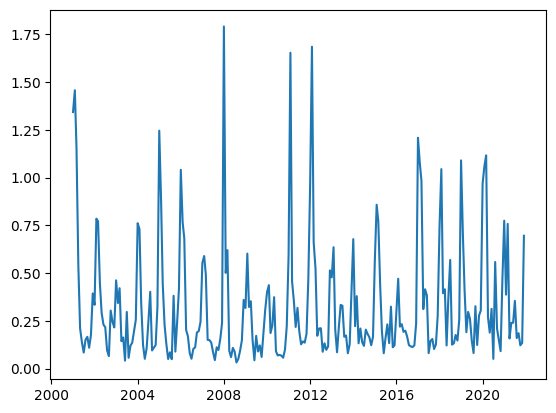

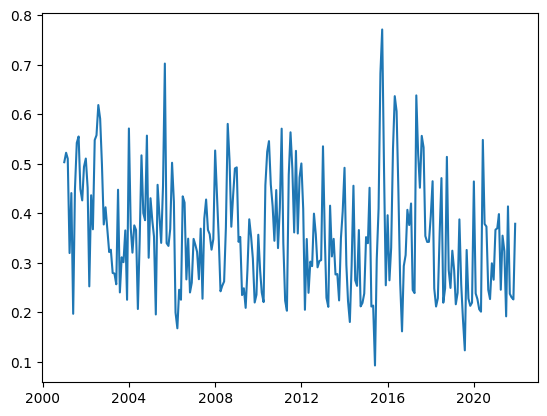

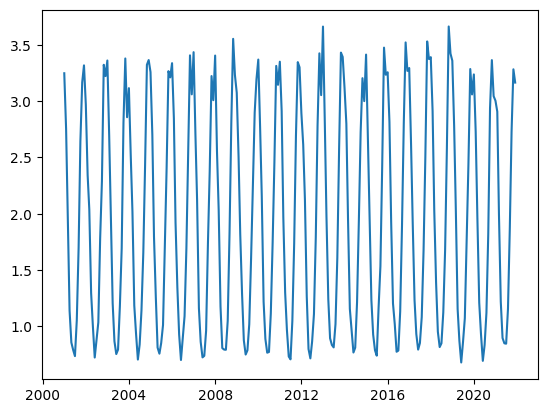

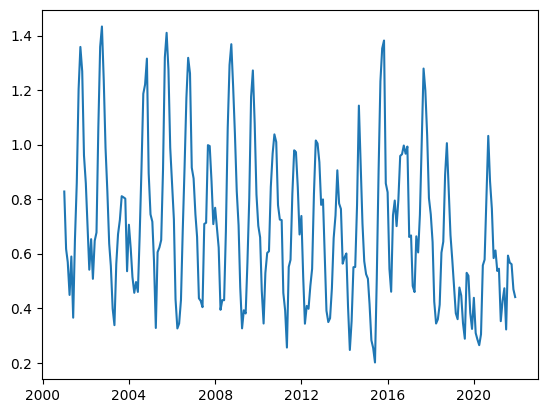

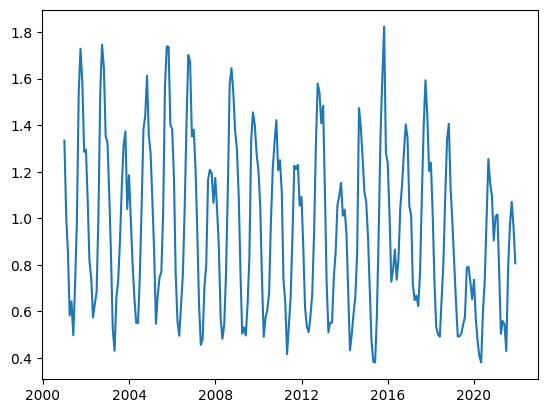

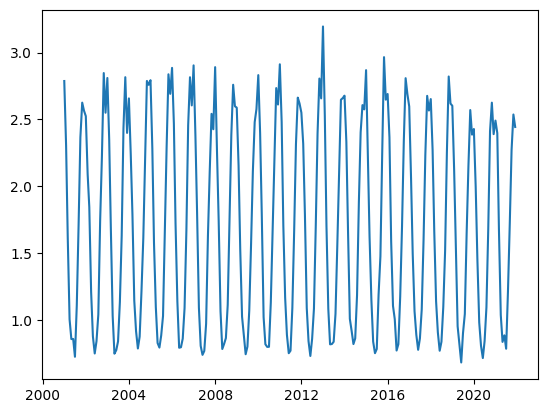

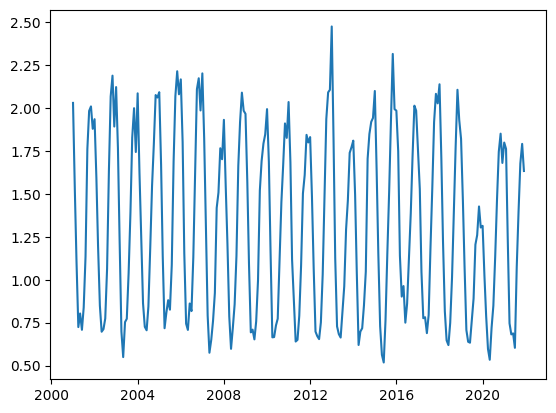

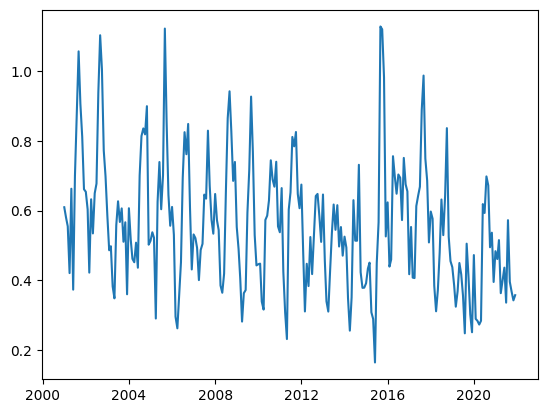

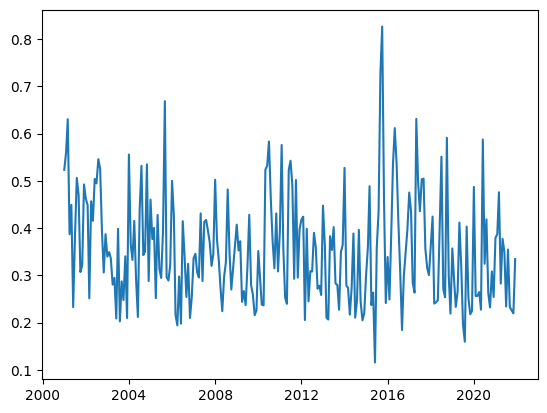

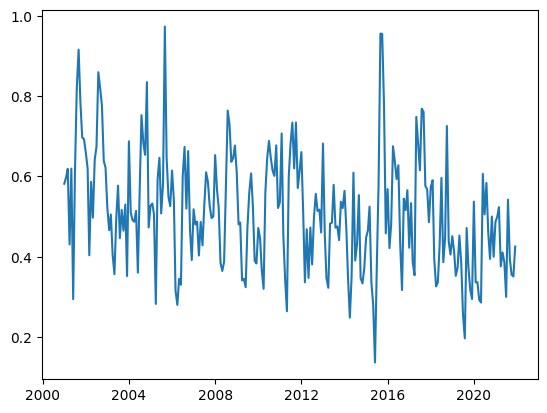

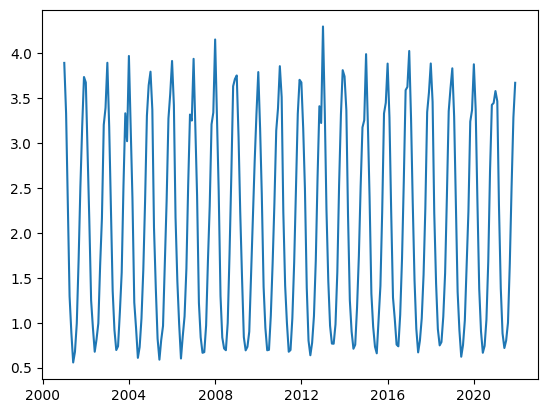

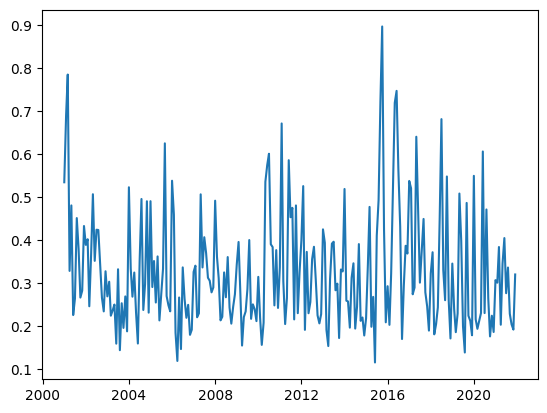

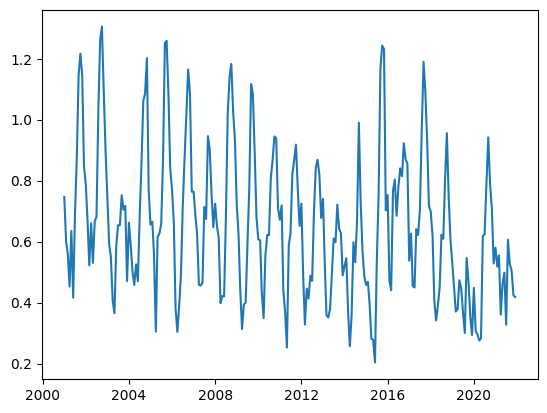

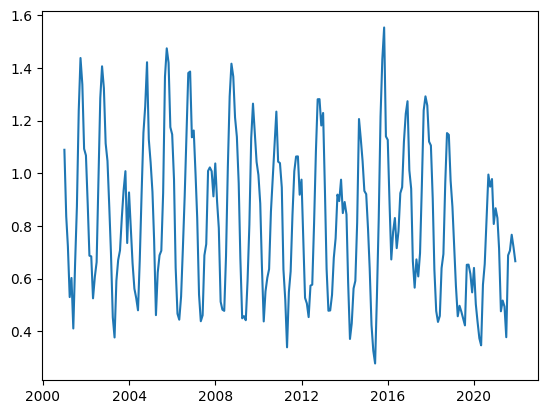

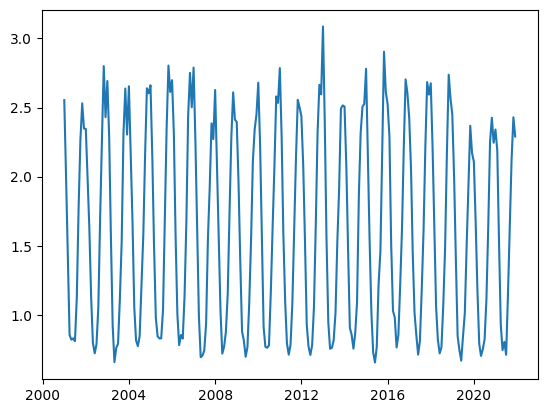

In [22]:
for n in basins:
    sub_df = df[df['NOM_CUEN'] == n]
    sub_df = sub_df.set_index(pd.to_datetime(sub_df['date']))
    plt.plot(sub_df['AET'])
    plt.show()